## 4.5.1　2层神经网络的类

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:
    """
    两层神经网络类
    具有一个隐藏层的神经网络，用于分类任务
    网络结构：输入层 -> 隐藏层(sigmoid激活) -> 输出层(softmax激活)
    """

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """
        初始化两层神经网络

        Parameters:
        -----------
        input_size : int
            输入层的节点数（特征维数）
        hidden_size : int
            隐藏层的节点数
        output_size : int
            输出层的节点数（类别数）
        weight_init_std : float, default=0.01
            权重初始化的标准差
        """
        # 初始化权重和偏置参数
        self.params = {}
        # 第一层权重：从输入层到隐藏层，形状为(input_size, hidden_size)
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        # 第一层偏置：隐藏层偏置，形状为(hidden_size,)
        self.params['b1'] = np.zeros(hidden_size)
        # 第二层权重：从隐藏层到输出层，形状为(hidden_size, output_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        # 第二层偏置：输出层偏置，形状为(output_size,)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        """
        前向传播预测

        Parameters:
        -----------
        x : ndarray
            输入数据，形状为(batch_size, input_size)

        Returns:
        --------
        y : ndarray
            预测结果（概率分布），形状为(batch_size, output_size)
        """
        # 获取权重和偏置参数
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        # 第一层：线性变换 + sigmoid激活
        a1 = np.dot(x, W1) + b1  # 线性变换：x*W1 + b1
        z1 = sigmoid(a1)         # sigmoid激活函数

        # 第二层：线性变换 + softmax激活
        a2 = np.dot(z1, W2) + b2  # 线性变换：z1*W2 + b2
        y = softmax(a2)           # softmax激活函数，输出概率分布

        return y

    def loss(self, x, t):
        """
        计算损失函数值（交叉熵误差）

        Parameters:
        -----------
        x : ndarray
            输入数据，形状为(batch_size, input_size)
        t : ndarray
            监督数据（正确标签），形状为(batch_size, output_size)

        Returns:
        --------
        loss : float
            交叉熵损失值
        """
        y = self.predict(x)  # 获取预测结果

        return cross_entropy_error(y, t)  # 计算交叉熵误差

    def accuracy(self, x, t):
        """
        计算识别精度

        Parameters:
        -----------
        x : ndarray
            输入数据，形状为(batch_size, input_size)
        t : ndarray
            监督数据（正确标签），形状为(batch_size, output_size)

        Returns:
        --------
        accuracy : float
            识别精度（0~1之间的值）
        """
        y = self.predict(x)           # 获取预测结果
        y = np.argmax(y, axis=1)      # 获取预测类别（概率最大的索引）
        t = np.argmax(t, axis=1)      # 获取正确类别（one-hot编码转为索引）

        # 计算预测正确的样本数占总样本数的比例
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """
        通过数值微分计算梯度（用于梯度检查）
        计算速度较慢，主要用于验证反向传播的正确性

        Parameters:
        -----------
        x : ndarray
            输入数据，形状为(batch_size, input_size)
        t : ndarray
            监督数据（正确标签），形状为(batch_size, output_size)

        Returns:
        --------
        grads : dict
            各参数的梯度字典，包含'W1', 'b1', 'W2', 'b2'的梯度
        """
        # 定义损失函数（固定输入x和标签t）
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        # 分别计算各参数的数值梯度
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])  # W1的梯度
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])  # b1的梯度
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])  # W2的梯度
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])  # b2的梯度

        return grads

    def gradient(self, x, t):
        """
        通过误差反向传播算法高效计算梯度
        计算速度比数值微分快很多，用于实际训练

        Parameters:
        -----------
        x : ndarray
            输入数据，形状为(batch_size, input_size)
        t : ndarray
            监督数据（正确标签），形状为(batch_size, output_size)

        Returns:
        --------
        grads : dict
            各参数的梯度字典，包含'W1', 'b1', 'W2', 'b2'的梯度
        """
        # 获取权重和偏置参数
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]  # 批量大小

        # === 前向传播 ===
        a1 = np.dot(x, W1) + b1   # 第一层线性变换
        z1 = sigmoid(a1)          # 第一层激活（隐藏层输出）
        a2 = np.dot(z1, W2) + b2  # 第二层线性变换
        y = softmax(a2)           # 第二层激活（最终输出）

        # === 反向传播 ===
        # 输出层的误差（softmax + 交叉熵的导数）
        dy = (y - t) / batch_num

        # 第二层参数的梯度
        grads['W2'] = np.dot(z1.T, dy)    # W2的梯度：z1^T * dy
        grads['b2'] = np.sum(dy, axis=0)   # b2的梯度：dy按行求和

        # 隐藏层的误差传播
        da1 = np.dot(dy, W2.T)            # 传播到隐藏层的误差
        dz1 = sigmoid_grad(a1) * da1      # sigmoid函数的导数

        # 第一层参数的梯度
        grads['W1'] = np.dot(x.T, dz1)    # W1的梯度：x^T * dz1
        grads['b1'] = np.sum(dz1, axis=0) # b1的梯度：dz1按行求和

        return grads

## 4.5.2 mini-batch的实现

train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.7780666666666667, 0.7823
train acc, test acc | 0.8791333333333333, 0.8827
train acc, test acc | 0.8989333333333334, 0.9017
train acc, test acc | 0.9071, 0.9086
train acc, test acc | 0.91385, 0.9154
train acc, test acc | 0.9189833333333334, 0.9212
train acc, test acc | 0.9231166666666667, 0.9249
train acc, test acc | 0.9258166666666666, 0.9264
train acc, test acc | 0.9294666666666667, 0.93
train acc, test acc | 0.9323333333333333, 0.9316
train acc, test acc | 0.9349833333333334, 0.9363
train acc, test acc | 0.9369166666666666, 0.9369
train acc, test acc | 0.9399166666666666, 0.9392
train acc, test acc | 0.94225, 0.9409
train acc, test acc | 0.9436833333333333, 0.9422
train acc, test acc | 0.9460166666666666, 0.9452


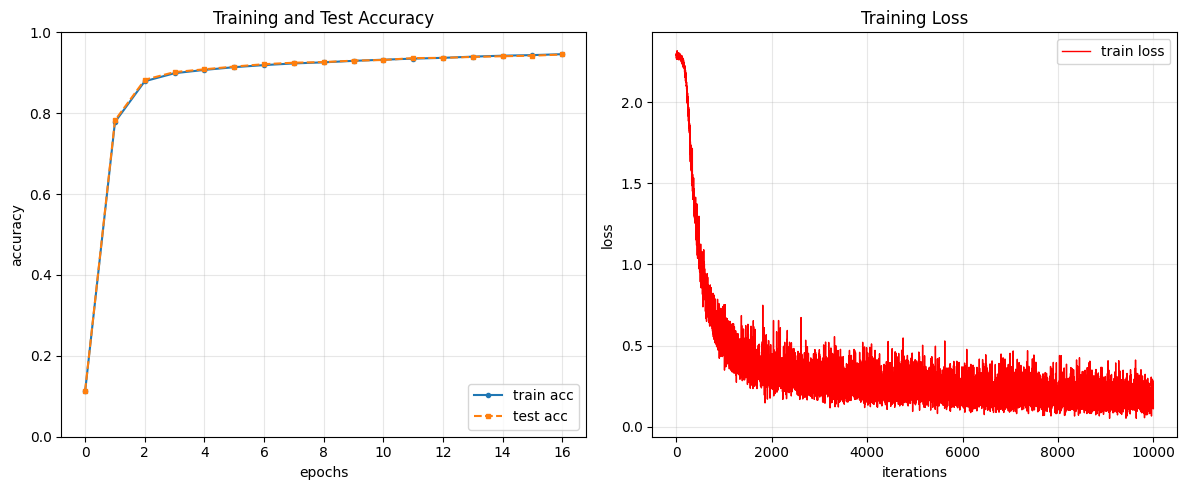

In [2]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 适当设定循环的次数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 计算梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 绘制图形 - 创建包含两个子图的图像
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 子图1：准确率变化图
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
ax1.plot(x, train_acc_list, label='train acc', marker='o', markersize=3)
ax1.plot(x, test_acc_list, label='test acc', linestyle='--', marker='s', markersize=3)
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_ylim(0, 1.0)
ax1.legend(loc='lower right')
ax1.set_title('Training and Test Accuracy')
ax1.grid(True, alpha=0.3)

# 子图2：损失函数变化图
x_loss = np.arange(len(train_loss_list))
ax2.plot(x_loss, train_loss_list, label='train loss', color='red', linewidth=1)
ax2.set_xlabel("iterations")
ax2.set_ylabel("loss")
ax2.legend(loc='upper right')
ax2.set_title('Training Loss')
ax2.grid(True, alpha=0.3)

# 调整子图间距
plt.tight_layout()
plt.show()